# CNNAutoencoder_3 — Mathematical Study Guide and Reference

This notebook is a rigorous, step-by-step mathematical reference for the CNNAutoencoder_3 used for histopathology patch reconstruction ($150\times150\times3$). It defines the full pipeline with exact equations, size transitions, receptive field analysis, attention, skip connections, objective functions, and visual flow diagrams.

## 1. Problem Setup and Notation

- Input: $x \in \mathbb{R}^{C\times H\times W}$, with $C=3$, $H=W=150$.
- Encoder $h_{\theta_e}: \mathbb{R}^{3\times150\times150} \to \mathbb{R}^{C_z\times H_z\times W_z}$.
- Decoder $g_{\theta_d}: \mathbb{R}^{C_z\times H_z\times W_z} \to \mathbb{R}^{3\times150\times150}$.
- Autoencoder: $f_\theta = g_{\theta_d} \circ h_{\theta_e}$.
- Reconstruction: $\hat{x} = f_\theta(x)$.

Normalization: images are typically normalized as $y = (x - \mu) / \sigma$. In this project, $\mu=(0.5,0.5,0.5)$, $\sigma=(0.5,0.5,0.5)$, mapping RGB values in $[0,1]$ to $[-1,1]$. The output uses $\tanh$ to match this range.

Objective (multi-term):

$\mathcal{L}(x, \hat{x}) = \alpha \, \mathcal{L}_{\text{MSE}}(x, \hat{x}) + \beta \, \mathcal{L}_{1}(x, \hat{x}) + \gamma \, \mathcal{L}_{\text{SSIM}}(x, \hat{x}) + \lambda \, \Omega(\theta)$

Where $\Omega(\theta)$ is weight decay (e.g., $\sum \lVert W \rVert^{2}$).

## 2. Convolution and Transposed Convolution — Exact Mathematics

### 2.1 2D Convolution (Conv2d)
Given $F_{\text{in}} \in \mathbb{R}^{C_{\text{in}}\times H\times W}$, weight $W \in \mathbb{R}^{C_{\text{out}}\times C_{\text{in}}\times k\times k}$, bias $b \in \mathbb{R}^{C_{\text{out}}}$, stride $s$, padding $p$:

$Y[c_{\text{out}}, i, j] = b[c_{\text{out}}] + \sum_{c=0}^{C_{\text{in}}-1} \sum_{u=0}^{k-1} \sum_{v=0}^{k-1} W[c_{\text{out}},c,u,v] \cdot F_{\text{in}}[c, \, s\,i + u - p, \, s\,j + v - p]$

Spatial size:

$H_{\text{out}} = \left\lfloor\frac{H + 2p - k}{s}\right\rfloor + 1, \quad W_{\text{out}} = \left\lfloor\frac{W + 2p - k}{s}\right\rfloor + 1$

### 2.2 Transposed Convolution (ConvTranspose2d)
Given $X \in \mathbb{R}^{C_{\text{in}}\times H\times W}$, $W \in \mathbb{R}^{C_{\text{in}}\times C_{\text{out}}\times k\times k}$, stride $s$, padding $p$, output\_padding $op$:

$H_{\text{out}} = (H - 1)\,s - 2p + k + op, \quad W_{\text{out}} = (W - 1)\,s - 2p + k + op$

This inverts downsampling (approximately) from the encoder.

## 3. Normalization and Activations

### 3.1 Batch Normalization (per channel)
$\mathrm{BN}(a) = \gamma \cdot \frac{a - \mu}{\sqrt{\sigma^{2} + \varepsilon}} + \beta$

where $\mu,\sigma^{2}$ are batch estimates, and $\gamma,\beta$ are learnable affine parameters.

### 3.2 GELU Activation
$\mathrm{GELU}(x) = x \cdot \Phi(x) = x \cdot \tfrac{1}{2} \cdot (1 + \operatorname{erf}(x/\sqrt{2}))$

Smooth, non-monotonic; empirically stabilizes and improves training.

### 3.3 Tanh Output
$\tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$, range $(-1,1)$.

Matches normalized image range when inputs are scaled to $[-1,1]$. 

## 4. Channel Attention (Squeeze-and-Excitation style)

Input $F \in \mathbb{R}^{C\times H\times W}$.

1) Squeeze:
$z^{\mathrm{avg}}_{c} = \frac{1}{H\,W} \sum_{i=1}^{H} \sum_{j=1}^{W} F[c,i,j], \quad z^{\mathrm{max}}_{c} = \max_{i,j} F[c,i,j]$

2) Excitation (two $1\times1$ convs as an MLP) with reduction $r=16$:
$s^{\mathrm{avg}} = \sigma(W_{2}\, \delta(W_{1} \, z^{\mathrm{avg}})), \quad s^{\mathrm{max}} = \sigma(W_{2}\, \delta(W_{1} \, z^{\mathrm{max}}))$

$s = \sigma(s^{\mathrm{avg}} + s^{\mathrm{max}}) \in (0,1)^{C}$

Here $W_{1} \in \mathbb{R}^{C/r \times C}$, $W_{2} \in \mathbb{R}^{C \times C/r}$, $\delta = \mathrm{ReLU}$, $\sigma = \mathrm{sigmoid}$.

3) Scale:
$\tilde{F}[c,i,j] = s_{c} \cdot F[c,i,j]$

This reweights channels by learned importance, improving SNR and feature selection.

## 5. CNNAutoencoder_3 — Encoder Specification (Layer-by-Layer)

Assumed blocks (consistent with stride-2, $k=3$, $p=1$ convs) to process $150\times150$ inputs:

- E1: $\mathrm{Conv2d}(3\to64,\, k=3,\, s=2,\, p=1) \to \mathrm{BN} \to \mathrm{GELU} \to \mathrm{ChannelAttention}(64)$
  - Size: $150 \to H_{1} = \left\lfloor\tfrac{150+2-3}{2}\right\rfloor + 1 = 75 \Rightarrow [64\times75\times75]$
- E2: $\mathrm{Conv2d}(64\to128,\, k=3,\, s=2,\, p=1) \to \mathrm{BN} \to \mathrm{GELU} \to (\mathrm{Dropout}) \to \mathrm{ChannelAttention}(128)$
  - Size: $75 \to H_{2} = \left\lfloor\tfrac{75+2-3}{2}\right\rfloor + 1 = 38 \Rightarrow [128\times38\times38]$
- E3: $\mathrm{Conv2d}(128\to256,\, k=3,\, s=2,\, p=1) \to \mathrm{BN} \to \mathrm{GELU} \to (\mathrm{Dropout}) \to \mathrm{ChannelAttention}(256)$
  - Size: $38 \to H_{3} = \left\lfloor\tfrac{38+2-3}{2}\right\rfloor + 1 = 19 \Rightarrow [256\times19\times19]$
- E4: $\mathrm{Conv2d}(256\to256,\, k=3,\, s=2,\, p=1) \to \mathrm{BN} \to \mathrm{GELU}$
  - Size: $19 \to H_{4} = \left\lfloor\tfrac{19+2-3}{2}\right\rfloor + 1 = 10 \Rightarrow$ bottleneck $Z \in [256\times10\times10]$

Bottleneck dimensionality: $10\times10\times256 = 25{,}600$. 

## 6. CNNAutoencoder_3 — Decoder with Skips (Layer-by-Layer)

We upsample using $\mathrm{ConvTranspose2d}(k=3,\, s=2,\, p=1,\, op=1)$, align encoder features via bilinear Resize, then concatenate and fuse with $\mathrm{Conv}+\mathrm{BN}+\mathrm{GELU}$.

- D1: $U_{1} = \mathrm{ConvT}(Z): \; 10\to20,\; 256\to256 \;\Rightarrow\; \widetilde{E}_{3}=\mathrm{Resize}(E_{3}:19\to20) \;\Rightarrow\; [U_{1}; \widetilde{E}_{3}]\in[512\times20\times20] \;\Rightarrow\; \mathrm{Conv}(512\to256)+\mathrm{BN}+\mathrm{GELU} = D_{1}$
- D2: $U_{2} = \mathrm{ConvT}(D_{1}): \; 20\to40,\; 256\to128 \;\Rightarrow\; \widetilde{E}_{2}:38\to40 \;\Rightarrow\; [U_{2}; \widetilde{E}_{2}]\in[256\times40\times40] \;\Rightarrow\; \mathrm{Conv}(256\to128)+\mathrm{BN}+\mathrm{GELU} = D_{2}$
- D3: $U_{3} = \mathrm{ConvT}(D_{2}): \; 40\to80,\; 128\to64 \;\Rightarrow\; \widetilde{E}_{1}:75\to80 \;\Rightarrow\; [U_{3}; \widetilde{E}_{1}]\in[128\times80\times80] \;\Rightarrow\; \mathrm{Conv}(128\to64)+\mathrm{BN}+\mathrm{GELU} = D_{3}$
- D4: $U_{4} = \mathrm{ConvT}(D_{3}): \; 80\to160,\; 64\to32 \;\Rightarrow\; \mathrm{Conv}(32\to3,\, k=3,\, s=1,\, p=1) \;\Rightarrow\; \tanh = R \in [3\times160\times160]$

Final size correction (GPU-friendly, differentiable):

$\hat{x} = \mathrm{Interpolate}(R,\; \text{size}=(150,150),\; \text{mode}=\text{bilinear},\; \text{align\_corners}=\text{False})$

This ensures exact output size even with odd input dimensions and stride-2 operations.

In [4]:
# 7. Shape and Size Tracker — exact integer arithmetic for all layers

import math

def conv2d_out(h, k=3, s=2, p=1):
    return (h + 2*p - k)//s + 1

def convt2d_out(h, k=3, s=2, p=1, op=1):
    return (h - 1)*s - 2*p + k + op

# Encoder sizes
H = 150
H1 = conv2d_out(H)   # 150 -> 75
H2 = conv2d_out(H1)  # 75  -> 38
H3 = conv2d_out(H2)  # 38  -> 19
H4 = conv2d_out(H3)  # 19  -> 10 (bottleneck)

# Decoder sizes (transposed convs)
U1 = convt2d_out(H4) # 10 -> 20
U2 = convt2d_out(U1) # 20 -> 40
U3 = convt2d_out(U2) # 40 -> 80
U4 = convt2d_out(U3) # 80 -> 160

print('Encoder sizes: 150 ->', H1, '->', H2, '->', H3, '->', H4)
print('Decoder sizes: ', H4, '->', U1, '->', U2, '->', U3, '->', U4)
print('Final interpolation from', U4, 'to 150.')

Encoder sizes: 150 -> 75 -> 38 -> 19 -> 10
Decoder sizes:  10 -> 20 -> 40 -> 80 -> 160
Final interpolation from 160 to 150.


## 8. Receptive Field (RF) Derivation

For a stack of layers with kernel sizes $k_i$, strides $s_i$, paddings $p_i$, define the jump $j_i$ and receptive field $r_i$ as:

- $j_{0} = 1$, $r_{0} = 1$
- After a Conv/ConvT layer $i$:
  - $j_{i} = j_{i-1} \cdot s_{i}$
  - $r_{i} = r_{i-1} + (k_{i} - 1) \cdot j_{i-1}$

For our encoder with $k=3$, $s=2$ each block, RF grows as:
- Layer 1: $r_{1} = 1 + (3-1)\cdot1 = 3$, $j_{1}=2$
- Layer 2: $r_{2} = 3 + 2\cdot2 = 7$, $j_{2}=4$
- Layer 3: $r_{3} = 7 + 2\cdot4 = 15$, $j_{3}=8$
- Layer 4: $r_{4} = 15 + 2\cdot8 = 31$, $j_{4}=16$

Thus each bottleneck unit (in $Z$) sees a $31\times31$ region in the input.

In [2]:
# 9. Receptive Field calculator for the encoder

def rf_run(ks, ss):
    r, j = 1, 1
    out = []
    for k, s in zip(ks, ss):
        r = r + (k - 1) * j
        j = j * s
        out.append((r, j))
    return out

ks = [3,3,3,3]
ss = [2,2,2,2]
print('RF, jump per layer:', rf_run(ks, ss))

RF, jump per layer: [(3, 2), (7, 4), (15, 8), (31, 16)]


## 10. Skip Connections — Mathematical Fusion

Let $E_i$ be encoder features at scale $i$ and $D_i$ be decoder features. With a resize operator $\mathcal{R}$ to match spatial size:

$D_{1} = \varphi_{1}(\, [\, U_{1} ; \mathcal{R}(E_{3}) \,] \,), \quad D_{2} = \varphi_{2}(\, [\, U_{2} ; \mathcal{R}(E_{2}) \,] \,), \quad D_{3} = \varphi_{3}(\, [\, U_{3} ; \mathcal{R}(E_{1}) \,] \,)$

where $[\cdot;\cdot]$ denotes channel-wise concatenation and $\varphi_i$ is $\mathrm{Conv}+\mathrm{BN}+\mathrm{GELU}$. This preserves fine details and improves gradient flow.

## 11. Objective Functions — Exact Forms

- Mean Squared Error (MSE): $\mathcal{L}_{\mathrm{MSE}} = \frac{1}{C\,H\,W} \sum_{c,i,j} (x[c,i,j] - \hat{x}[c,i,j])^{2}$
- L1 Loss: $\mathcal{L}_{1} = \frac{1}{C\,H\,W} \sum_{c,i,j} \lvert x[c,i,j] - \hat{x}[c,i,j] \rvert$
- SSIM (windowed): $\mathrm{SSIM}(x,y) = \frac{(2 \, \mu_{x} \, \mu_{y} + C_{1})(2 \, \sigma_{xy} + C_{2})}{(\mu_{x}^{2} + \mu_{y}^{2} + C_{1})(\sigma_{x}^{2} + \sigma_{y}^{2} + C_{2})}$

Total: $\mathcal{L} = \alpha\,\mathcal{L}_{\mathrm{MSE}} + \beta\,\mathcal{L}_{1} + \gamma\,(1 - \mathrm{SSIM}) + \lambda\,\Omega(\theta)$.

## 12. Backpropagation Notes

- Convolution: gradients are cross-correlations of upstream gradients with input patches.
- BN: gradients through normalization and affine parameters (γ,β).
- GELU: d/dx GELU(x) = Φ(x) + x·ϕ(x), with ϕ the standard normal pdf.
- Attention: gradients flow through the MLP and sigmoid to scaling s.
- Interpolation: bilinear is piecewise polynomial and differentiable almost everywhere.

NameError: name 'narrow' is not defined

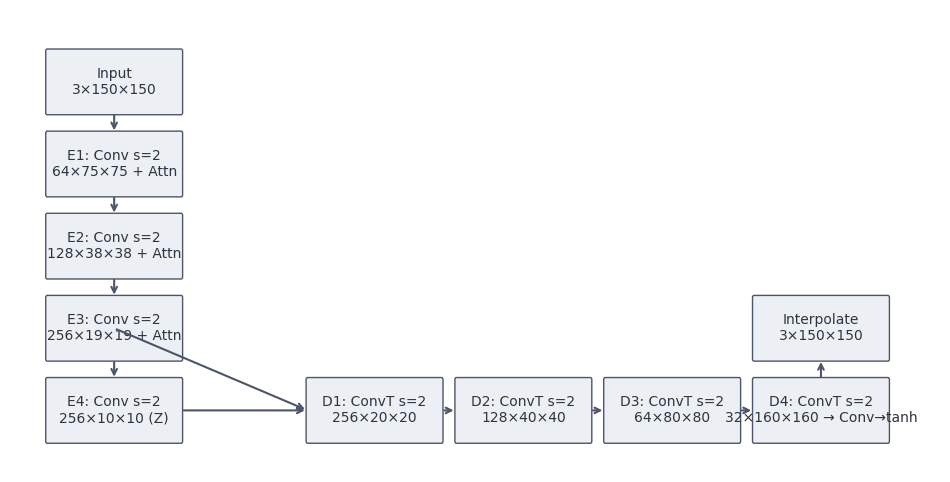

In [9]:
# 13. Flowchart Visualization with matplotlib

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Force white backgrounds regardless of global style
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'


def box(ax, xy, text, fc='#eceff4', ec='#4c566a', text_color='#2e3440'):
    x, y = xy
    w, h = 1.8, 0.6
    rect = FancyBboxPatch((x, y), w, h, boxstyle='round,pad=0.02', fc=fc, ec=ec)
    ax.add_patch(rect)
    ax.text(x + w / 2, y + h / 2, text, ha='center', va='center', fontsize=10, color=text_color)
    return (x + w / 2, y + h)


def arrow(ax, p1, p2, color='#4c566a'):
    ax.annotate('', xy=p2, xytext=p1, arrowprops=dict(arrowstyle='->', lw=1.5, color=color))


fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
ax.set_facecolor('white')
ax.axis('off')

# Keep everything within explicit limits so nothing is clipped
ax.set_xlim(0.0, 12.5)
ax.set_ylim(0.0, 4.5)

# Encoder chain
c1 = box(ax, (0.5, 3.5), 'Input\n3×150×150')
c2 = box(ax, (0.5, 2.7), 'E1: Conv s=2\n64×75×75 + Attn')
c3 = box(ax, (0.5, 1.9), 'E2: Conv s=2\n128×38×38 + Attn')
c4 = box(ax, (0.5, 1.1), 'E3: Conv s=2\n256×19×19 + Attn')
c5 = box(ax, (0.5, 0.3), 'E4: Conv s=2\n256×10×10 (Z)')
arrow(ax, (1.4, 3.5), (1.4, 3.3))
arrow(ax, (1.4, 2.7), (1.4, 2.5))
arrow(ax, (1.4, 1.9), (1.4, 1.7))
arrow(ax, (1.4, 1.1), (1.4, 0.9))

# Decoder chain
d1 = box(ax, (4.0, 0.3), 'D1: ConvT s=2\n256×20×20')
d2 = box(ax, (6.0, 0.3), 'D2: ConvT s=2\n128×40×40')
d3 = box(ax, (8.0, 0.3), 'D3: ConvT s=2\n64×80×80')
d4 = box(ax, (10.0, 0.3), 'D4: ConvT s=2\n32×160×160 → Conv→tanh')
out = box(ax, (10.0, 1.1), 'Interpolate\n3×150×150')

# Main arrows
arrow(ax, (2.3, 0.6), (4.0, 0.6))
arrow(ax, (5.8, 0.6), (6.0, 0.6))
arrow(ax, (7.8, 0.6), (8.0, 0.6))
arrow(ax, (9.8, 0.6), (10.0, 0.6))
arrow(ax, (10.9, 0.9), (10.9, 1.1))

# Skip arrows (schematic)
arrow(ax, (1.4, 1.4), (4.0, 0.6))   # E3 -> D1
narrow(ax, (1.4, 2.2), (6.0, 0.6))   # E2 -> D2
narrow(ax, (1.4, 3.0), (8.0, 0.6))   # E1 -> D3

plt.tight_layout()
plt.show()

## 15. Practical Notes

- Use RGB normalization mean = $(0.5, 0.5, 0.5)$, std = $(0.5, 0.5, 0.5)$.
- Output $\tanh$ to match $[-1,1]$.
- Learning rate scheduling (e.g., ReduceLROnPlateau) helps convergence.
- Interpolate to exact $(150,150)$ to handle odd dimensions with stride-2 pyramids.
- Channel attention boosts relevant features; skips preserve edges and textures.

## 15. Practical Notes

- Use RGB normalization mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5).
- Output tanh to match [−1,1].
- Learning rate scheduling (e.g., ReduceLROnPlateau) helps convergence.
- Interpolate to exact (150,150) to handle odd dimensions with stride-2 pyramids.
- Channel attention boosts relevant features; skips preserve edges and textures.